<a href="https://colab.research.google.com/github/Kuzay3t/2D-Image-Reconstruction/blob/main/2d_image_reconstruction_MNIST_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# importing necessary libaries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import mean_squared_error

In [10]:
# Load dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

In [11]:
# Add noise to images
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [12]:
# Normalize to [0, 1] and add channel dimension (needed for Conv2D)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)

In [13]:
# building the autoencoder model

# Encoder
input_img = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2)(input_img)  # 14x14x16
x = layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2)(x)         # 7x7x32
x = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=1)(x)         # 7x7x64



In [14]:
# Decoder
x = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=1)(x) # 7x7x32
x = layers.Conv2DTranspose(16, (3,3), activation='relu', padding='same', strides=2)(x) # 14x14x16
x = layers.Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same', strides=2)(x) # 28x28x1



In [15]:
autoencoder = models.Model(input_img, x)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 7, 7, 32)       │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │           145 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,529 (181.75 KB)

 Trainable params: 46,529 (181.75 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train on noisy images, target is clean images
autoencoder.fit(x_train_noisy, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - loss: 0.1265 - val_loss: 0.1140
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - loss: 0.1121 - val_loss: 0.1140


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


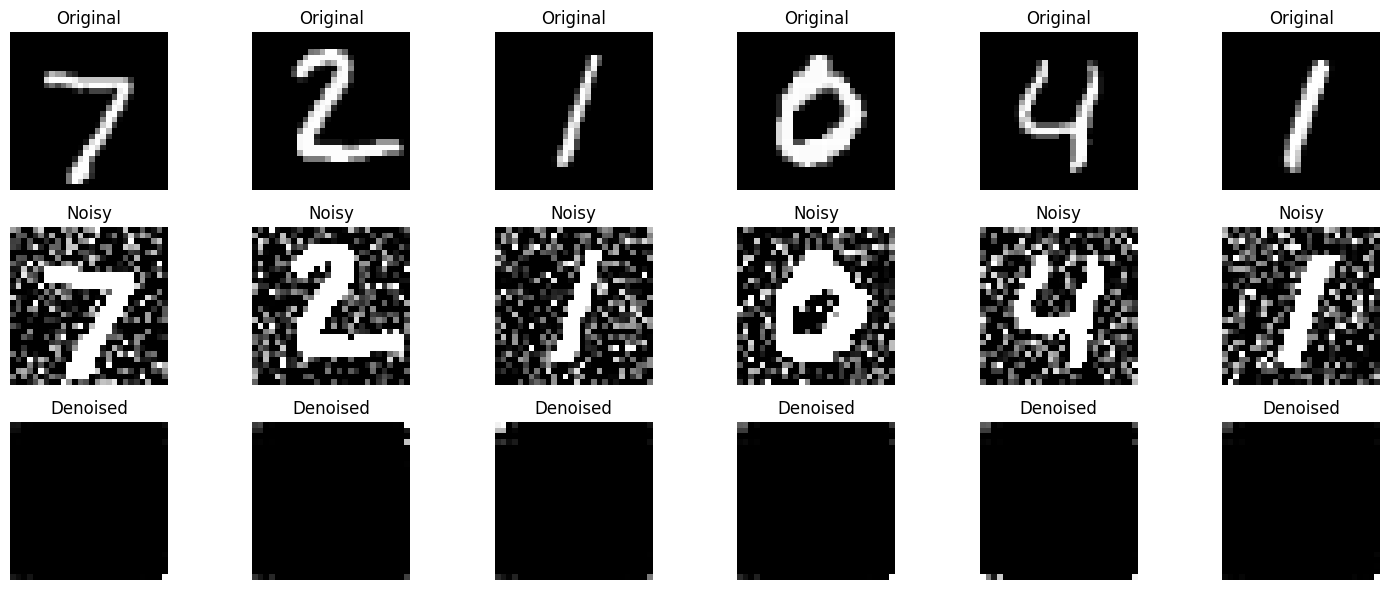

In [17]:
# Visualize
decoded_imgs = autoencoder.predict(x_test_noisy[:6])

plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.imshow(x_test[i].reshape(28,28), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    plt.subplot(3, 6, i+7)
    plt.imshow(x_test_noisy[i].reshape(28,28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')
    plt.subplot(3, 6, i+13)
    plt.imshow(decoded_imgs[i].reshape(28,28), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
# Calculate MSE between the original test images and the denoised images
mse_score = mean_squared_error(x_test[:6].reshape(-1, 28*28), decoded_imgs.reshape(-1, 28*28))
print("MNIST Reconstruction MSE:", mse_score)

MNIST Reconstruction MSE: 0.09025758504867554
